# Population stratification 

::: {.callout-note title="Important notes for this notebook" icon=false}

As we’ve discussed, removing population structure is crucial, as residual population stratification—highlighted by [@sohail2019polygenic]—can even be detected in published GWAS. This can lead to biased effect size estimates, impacting polygenic risk scores and other downstream analyses. In this notebook, we will further explore one way of detecting population stratification in GWAS. Since we were uncertain whether we were being too strict when correcting for population structure, or if the GWAS lacked sufficient power, this analysis will help us clarify if we can trust our results. 

## Learning outcomes

- Identify potential population stratification in our GWAS output. 

## How to make this notebook work

* In this notebook, we will use both `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images. We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel
 
:::



### Correlation between PC loadings and effect sizes
We followed a similar approach from [@sohail2019polygenic] to examine GWAS stratification along different PCA axes of population structure. We began by performing a PCA on the genotype data from the 1000 Genomes Project used in the previous notebook. Then, we computed the correlation between the first 10 PCA loadings and the effect size estimates from the GWAS conducted on the Hapmap data. We visualized these PC-specific correlations to explore patterns of stratification along different axes of genetic variation. Additionally, it would be very useful to consider allele frequency differences across different populations when analyzing such stratification.

We use PLINK's `--pca var-wts` command on the set of independent variants (`indepSNP.prune.in`) to obtain the PC loadings.

In [1]:
plink --bfile Results/GWAS4/1kG_MDS6  --extract Results/GWAS3/indepSNP.prune.in --pca 10 var-wts --out Results/GWAS4/PCA_1kg --silent

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Now we will plot the correlation between the loadings and the effect sizes for both GWAS results from GWAS5. 

#### A. Summary statistics from `--assoc` test

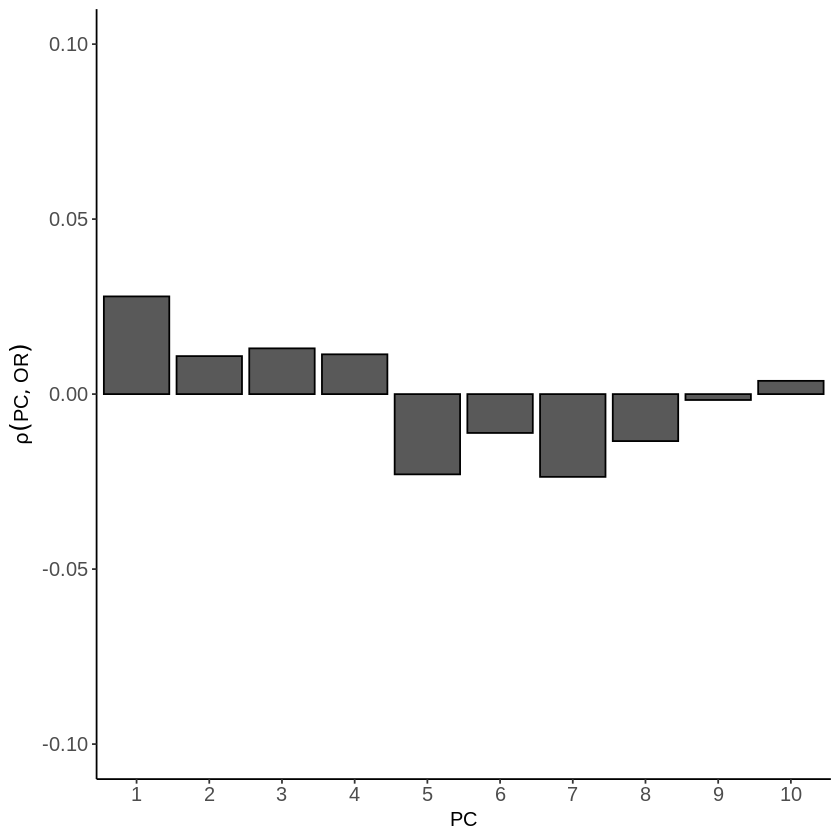

In [29]:
library(ggplot2)

# load the data 
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
data <- read.table(file="Results/GWAS4/PCA_1kg.eigenvec.var",header=FALSE)
colnames(data) <- c("CHROM", "ID", "a1", "a2", 
                    paste0("PC", 1:10))  # PC1 to PC10
# merge data 
merged_tab <- merge(results_as, data, by=2)
# compute correlations 
correlations <- apply(merged_tab[, 14:23], 2, function(x) cor(merged_tab$OR, x, method="pearson", use="complete.obs"))

dataCor <- data.frame(
  pc = 1:10,
  corr = correlations)


ggplot(as.data.frame(dataCor), aes(pc, corr)) +
    ylab(expression(rho(PC, OR))) +
    geom_bar(stat='identity', position='dodge', col='black')+
    xlab('PC') + 
    ylim(c(-0.1,0.1)) +
    scale_x_continuous(breaks=seq(1,10,1), expand=c(0,0.1))+
    theme(panel.grid.minor=element_blank(), panel.background = element_blank(),
            axis.line = element_line(), axis.text= element_text(size=12),
          axis.title= element_text(size=12))


#### B. Summary statistics from `--logistic` test

Let's calculate Pearson correlations using the logistic model results.

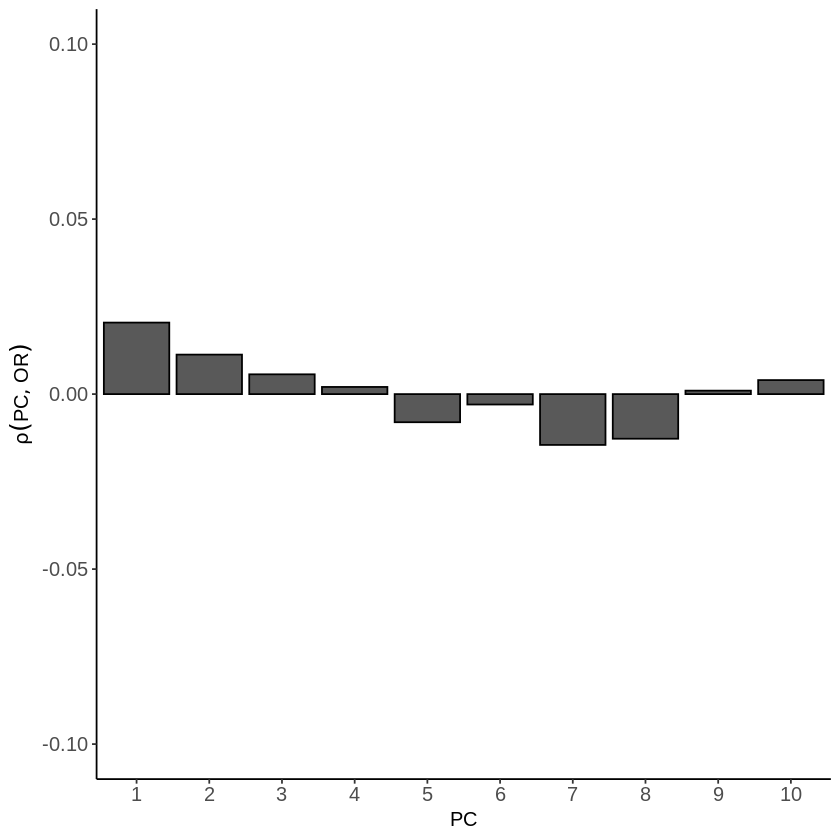

In [28]:
# load results logistic model 
results_log <- read.table("Results/GWAS5/logistic_results.assoc_2.logistic", head=TRUE)


merged_log <- merge(results_log, data, by=2)
# compute correlations 
correlationsLog <- apply(merged_log[, 13:22], 2, function(x) cor(merged_log$OR, x, method="pearson", use="complete.obs"))

dataCorLog <- data.frame(
  pc = 1:10,
  corr = correlationsLog)


ggplot(as.data.frame(dataCorLog), aes(pc, corr)) +
    ylab(expression(rho(PC, OR))) +
    geom_bar(stat='identity', position='dodge', col='black')+
    xlab('PC') + 
    ylim(c(-0.1,0.1)) +
    scale_x_continuous(breaks=seq(1,10,1), expand=c(0,0.1))+
    theme(panel.grid.minor=element_blank(), panel.background = element_blank(),
            axis.line = element_line(), axis.text= element_text(size=12),
          axis.title= element_text(size=12))



There should be no correlation if we had corrected for population structure, as the effect size estimates wouldn’t be influenced by that. In contrast, for the model that doesn’t account for covariates, the correlations are higher than those observed in the logistic model. These correlations may help explain why the logistic model, which accounts for covariates, did not produce significant peaks in the Manhattan plot. Therefore, the lack of significant associations might not be due to being overly cautious but could rather indicate the true absence of strong signals. Further investigation is needed to better understand these results.

For interpretation, coloring the bar plot results based on the correlation between the PCs and the allele frequency difference between the populations represented in your target sample would help highlight any patterns or trends.


:::{.callout-tip title="Other take-home messages"}

- Population structure can be addressed using principal components (PCs) and mixed models, though never perfectly. If your effect size estimates correlate with a PC, it is advisable to run a linear mixed model (e.g., BOLT-LMM). However, be cautious—these approaches mitigate, but do not entirely eliminate, the risk of residual confounding, so results should be interpreted carefully.
- Controlling for population structure is crucial because residual population stratification can introduce spurious associations. Researchers might perform meta-analyses to increase statistical power by combining data from multiple studies. However, population structure bias is unlikely to be consistent across studies. If not properly accounted for, this bias can distort results, leading to false associations rather than true genetic signals.

:::